# Homework 3 - Ludek Cizinsky, 377297

In this homework, we are going to work with the transformer. There are three parts of this homework.

- In the first part, we are going to implement **positional encoding** and **self-attention**  and test them on a simple text dataset which contains around 100 sentences. We will use a small transformer in this task.

- In the second part, we will detect promoters from the DNA sequences. The main difference compared to the previous task is to tokenize the DNA sequence. Thus, our task here is to build the **tokenizer** to tokenize the DNA sequence. For the model, we will continue using the small transformer.

- In the third part, we will use a **foundation model** DNABERT to perform promoter detection. In this part, you do not need to train the transformer. Instead, you need to find and load the correct pre-trained model and then use it to get the embedding of the DNA sequence. Then, you will build a simple classifier to perform promoter detection based on the DNA embedding.

## 0. Initialization

Import the packages you are going to use here.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import random
import numpy as np
from torchmetrics.classification import BinaryF1Score

import ipywidgets as widgets
from types import SimpleNamespace
from utils import data, evaluation, models, visualization, text_exercise

# Additional imports
# -- Training / Testing
from sklearn.model_selection import train_test_split

# -- Visualization
from sklearn.decomposition import PCA
from bhtsne import tsne
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_palette("RdYlBu")

# -- Misc
import math
import os
from tqdm import tqdm

Set the hyperparameters.

In [2]:
# Set seeds
seed = 128
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Note for TA:** The code below will download my extracted embeddings for both custom embedder (section 2) as well as dnabert (section 3). In addition, it will download the trained promoter classifiers based on these embedders. This should help you to run the notebook without having to train the models yourself and thus save you some time. If you want to train the models yourself, you can set `DOWNLOAD_RESULTS = False` and the notebook will train the models for you.

In [3]:
DOWNLOAD_RESULTS = True

if DOWNLOAD_RESULTS:
    from huggingface_hub import hf_hub_download

    # Specify the username and repository name
    repoid = "ludekcizinsky/epfl-cs502-hw3"
    files = ["embeddings.zip", "models.zip"]

    # Download all files from the repository
    for file in files:
        hf_hub_download(repoid, filename=file, local_dir="./", local_dir_use_symlinks=False, repo_type="dataset")
        os.system(f"unzip {file}")    
        os.remove(file)


embeddings.zip:   0%|          | 0.00/6.14M [00:00<?, ?B/s]

Archive:  embeddings.zip
   creating: embeddings/
   creating: embeddings/dnabert/
   creating: embeddings/custom/
   creating: embeddings/dnabert/test/
   creating: embeddings/dnabert/train/
   creating: embeddings/custom/test/
   creating: embeddings/custom/train/
  inflating: embeddings/dnabert/test/y.pth  
  inflating: embeddings/dnabert/test/x.pth  
  inflating: embeddings/dnabert/train/y.pth  
  inflating: embeddings/dnabert/train/x.pth  
  inflating: embeddings/custom/test/y.pth  
  inflating: embeddings/custom/test/x.pth  
  inflating: embeddings/custom/train/y.pth  
  inflating: embeddings/custom/train/x.pth  


models.zip:   0%|          | 0.00/2.45M [00:00<?, ?B/s]

Archive:  models.zip
   creating: models/
  inflating: models/dna_embedder_masklen-3.pth  
  inflating: models/dna_embedder_masklen-1.pth  
  inflating: models/customemb_promclf.pth  
  inflating: models/dnabert_promclf.pth  


## 1. Positional Encoding and Self-Attention (7 pts)

---

### 1.1. Sinusoidal Positional Encoding (1 pt)

In this section, you are going to implement the sinusoidal positional encoding. The formula is as the following:

<div>
<img src="./imgs/positional embedding.png" width="400"/>
</div>

where $t$ is the desired position in the input and $\mathsf{\omega}_k$ follows:

<div>
<img src="./imgs/omega.png" width="200"/>
</div>

To see the details of sinusoidal positional encoding, you can check this [link](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/).

In [4]:
class PositionalEmbedding(nn.Module):

    def __init__(self, max_position_embeddings, hidden_size, device):
        super().__init__()

        '''Construct the positional embedding.

        Args:
            max_position_embeddings (int): maximum length of the input - related to t in the previous formula
            hidden_size (int): encoding dimension - d in the previous formula 
        '''

        # Account for odd hidden size dimension by assuming first we have even dimension
        # In the last step, we will just drop the last column
        is_odd = hidden_size % 2
        if is_odd:
            hidden_size += 1 

        # Compute weights for the positional embedding
        k = torch.arange(hidden_size//2, dtype=torch.float32, device=device)
        w = 1 / (10000 ** (2*k/hidden_size))

        # Compute the positional embedding
        t = torch.arange(max_position_embeddings, dtype=torch.float32, device=device)
        sin = torch.sin(torch.outer(t, w)) # n x d/2
        cos = torch.cos(torch.outer(t, w))  # n x d/2

        # Put the sin and cos together
        self.positional_embedding = torch.zeros((max_position_embeddings, hidden_size), device=device)
        self.positional_embedding[:, 0::2] = sin
        self.positional_embedding[:, 1::2] = cos

        # Drop the last column
        if is_odd:
            self.positional_embedding = self.positional_embedding[:, :-1]
        
    def forward(self, x):
        return self.positional_embedding
    
    def embedding(self):
        return self.positional_embedding

Here, you can visualize your positional encoding. If you implement everything correctly, you can get a figure that is similar to Figure 2 in this [link](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/).

In [5]:
visualize_embedding, dimension_selector, max_len_selector = visualization.display_positional_encoding(PositionalEmbedding)
ui = widgets.HBox([max_len_selector, dimension_selector])  
out = widgets.interactive_output( visualize_embedding, {'max_len': max_len_selector, 'dimension': dimension_selector})
display(ui, out)

Output()

### 1.2. Self-Attention Mechanism (5 pts)

In this section, you are going to implement the self-attention mechanism. Please check the section 'Self-Attention in Detail' in this [link](https://jalammar.github.io/illustrated-transformer/) for the details of self-attention mechanism. (We encourage you to carefully go through the link since it is a very good tutorial for transformer.)

The specific steps will be provided in the comments of the following code. (The steps are only for reference. You do need to follow the steps if you have a better way to implement it.)

In [6]:
class BertSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (config.hidden_size, config.num_attention_heads)
            )
        self.output_attentions = config.output_attentions
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states, attention_mask=None, head_mask=None, encoder_hidden_states=None, encoder_attention_mask=None):
        """
        Args:
            hidden_states (torch.Tensor): input sequence (shape (batch_size, sequence_length, hidden_size))
            attention_mask (torch.Tensor): attention mask
            head_mask (torch.Tensor): head mask
            encoder_hidden_states (torch.Tensor): encoder hidden states of shape
            encoder_attention_mask (torch.Tensor): encoder attention mask of shape
        
        Returns:
            torch.Tensor: context layer of shape (batch_size, sequence_length, hidden_size)
            torch.Tensor: attention probabilities (optinal)
        """

        # Resulting shape: (batch_size, sequence_length, all_head_size)
        mixed_key_layer = self.key(hidden_states)
        mixed_query_layer = self.query(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        # Resulting shape: (batch_size, num_attention_heads, sequence_length, attention_head_size)
        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        # Resulting shape: (batch_size, num_attention_heads, sequence_length, sequence_length)
        # For each input token, we have unnormalized scores for all other tokens in the input sequence
        attention_scores = query_layer @ key_layer.transpose(-1, -2) / math.sqrt(self.attention_head_size)
        
        # Explanation of attention_mask: https://lukesalamone.github.io/posts/what-are-attention-masks/
        if attention_mask is not None:
            attention_scores = attention_scores + attention_mask

        # Normalize the attention scores
        attention_probs = F.softmax(attention_scores, dim=-1)

        # Apply dropout
        attention_probs = self.dropout(attention_probs)

        # (optional) Apply head mask if provided
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        # Reweight each token embeddings by the attention scores
        # Shape: (batch_size, num_attention_heads, sequence_length, attention_head_size)
        context_layer = attention_probs @ value_layer

        # Concatenate all the attention heads together
        head_outputs = torch.split(context_layer, 1, dim=1)
        context_layer = torch.cat(head_outputs, dim=-1).squeeze(1)

        # Get the output
        outputs = (context_layer, attention_probs) if self.output_attentions else (context_layer,)
        return outputs

Let's test your implementation using simple text data! First, let's load the data.

We use a small dataset in this homework for a shorter training time.

In [7]:
# ChatGPT generated text data about BERT
text = text_exercise.get()
sentences_df, vocab = data.to_sentence_df(text)

After loading the data, you can train your model. Here we train our model using masked token prediction.

Hint: The final model accuracy should be higher than 0.9.

In [8]:
text_max_len = 11

text_config = SimpleNamespace(
        vocab_size=len(vocab),
        hidden_size=60,
        max_position_embeddings=text_max_len,
        type_vocab_size=1,
        layer_norm_eps=1e-12,
        hidden_dropout_prob=0.0,
        attention_probs_dropout_prob=0.0,
        num_attention_heads=1,
        hidden_act="gelu",
        intermediate_size=160,
        num_hidden_layers=1,
        is_decoder=False,
        output_attentions=True,
        output_hidden_states=False,
        pruned_heads = {},
        initializer_range=0.02,
        device="cpu"
    )

tokenizer = data.TextTokenizer(vocab)
input_ids, segment_ids, masked_lm_labels, labels_idx, labels, attention_masks = data.generate_masked_data(sentences_df, tokenizer, k=1, max_len=text_max_len, noise_rate=0.4)

model = models.BertForMaskedLM(config=text_config, positional_embedding=PositionalEmbedding, attention=BertSelfAttention)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
print(f"Number of trainable model parameters: {models.number_of_model_parameters(model)}")

for epoch in range(200):
    optimizer.zero_grad()
    loss, outputs, attentions = model(
        input_ids=input_ids,
        token_type_ids=segment_ids,
        masked_lm_labels=masked_lm_labels,
        attention_mask=attention_masks
    )
    if (epoch + 1) % 20 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(loss))
    loss.backward()
    optimizer.step()

print(f"Final model accuracy: {evaluation.masked_label_accuracy(labels, labels_idx, outputs.data)}")

Number of trainable model parameters: 64910
Epoch: 0020 loss = 4.318673
Epoch: 0040 loss = 3.677480
Epoch: 0060 loss = 3.112207
Epoch: 0080 loss = 2.644524
Epoch: 0100 loss = 2.236955
Epoch: 0120 loss = 1.832929
Epoch: 0140 loss = 1.427701
Epoch: 0160 loss = 1.050064
Epoch: 0180 loss = 0.719200
Epoch: 0200 loss = 0.474754
Final model accuracy: 1.0


### 1.3. Visualize Attention (1 pt)

Here, you can visualize the self-attention. 

Question: Can you interpret the visualization of the self-attention?

**Answer:** In each row, we have weights that denote the importance of each token in the input sequence for the current token (ith token). The darker the color, the more important the token is. Generally, we would expect the model to pay attention to tokens close to the current token, making the diagonal of the matrix darker. However, we observe that our model focuses attention on a few specific words rather arbitrarily (the column(s) appear dark). The most likely explanation for such behavior is the small size of the dataset. The model has likely memorized the training data and does not generalize well.

In [9]:
visualize_attention, sample_id_selector = visualization.display_attantion(attentions=attentions, input_ids=input_ids, tokenizer=tokenizer)
widgets.interactive(visualize_attention, sample_id=sample_id_selector)

interactive(children=(Dropdown(description='Sample:', options=(5, 8, 11, 13, 18, 24, 26, 29, 31, 35, 37, 38, 6…

### 1.4. Train on small Wikitext Dataset

Here, you can **optionally** test your model on the smallest wikitext dataset. You should get an test accuracy around 0.4 after training 50 epochs.

This part is only for you to test your code. You can choose to run it or not. It takes around 1 hour to train the model for 50 epochs on the smallest wikitext dataset with Google Colab.

In [10]:
# text_exercise.train_wikitext(device, positional_embedding=PositionalEmbedding, attention=BertSelfAttention)

## 2. Promoter detection (7 pts)

---

In this section, we detect promoter in DNA sequence.

A promoter is a region of DNA upstream of a gene where relevant proteins (such as RNA polymerase and transcription factors) bind to initiate transcription of that gene. Promoter detection is to identify if there are promoter regions in the given DNA sequence. We have covered this in the lecture. (If you are interested in the promoter, you can check this [link](https://www.genome.gov/genetics-glossary/Promoter) for more details.)

Here, we use a transformer and a classifier. The transformer first embeds the DNA sequences into features, and then the classifier detects the promoter based on the features.

The main difference between text and DNA sequence is how to tokenize the sequence. Thus, you need to implement a tokenizer for the DNA sequence.

### 2.1. DNA Tokenizer (1 pts)

Here, you will implement the DNA tokenizer the same as in DNABERT. Please check this [paper](https://academic.oup.com/bioinformatics/article/37/15/2112/6128680) for implementation details. Also, you need to check the data type and shape for both input and output.

In [11]:
class DNATokenizer(data.Tokenizer):
    def __init__(self, k, vocab, unknown="[UNK]"):
        """
        K-mer tokenizer for DNA sequences.
        Args:
            k (int): k-mer size
            vocab (list): list of tokens
            unknown (str): unknown token
        """
        super().__init__(vocab, unknown)
        self.k = k

    def _parse_text(self, text):
        """Splits the text into k-mers and adds special tokens to the start and end of the sequence.
        Args:
            text (str): text to be tokenized 
        Returns:
            list: list of tokens 
        Notes:
        [CLS] is denoting a special token that can be used later for classification, the idea behind
        is that it should represent the whole sequence [SEP] is denoting the end of the sequence.
        """
        n = len(text)
        return ['[CLS]'] + [text[i:i + self.k] for i in range(n - self.k + 1)] + ['[SEP]']

### 2.2. Test BERT on DNA Sequence

In this section, you will train BERT on DNA sequence to learn the embedding of DNA sequence. The code is provided below and you do not need to write anything.

Hint: the final evaluation accuracy should be higher than 0.2.

**Note for TA:** I put the training/eval code into functions so there is no code redundancy.

a. Create helpers for training and evaluation of embedders

In [12]:
def embedding_eval_loop(model, test_loader, device):
    """
    Evaluate the embedding model on the test data.

    Args:
        model (nn.Module): model
        test_loader (DataLoader): test data loader
        device (torch.device): device to use for the evaluation
    
    Returns:
        float: average evaluation loss across the batches
    """
    # Set the model to eval mode
    model.eval()

    # Evaluate data
    total_eval_loss = 0
    for batch_input_ids, batch_segment_ids, batch_masked_lm_labels, _, _, batch_attention_mask in test_loader:

        # Evaluate the batch
        with torch.no_grad():

            # Forward pass
            loss, _, _, _ = model(
                input_ids=batch_input_ids.to(device),
                token_type_ids=batch_segment_ids.to(device),
                masked_lm_labels=batch_masked_lm_labels.to(device),
                attention_mask=batch_attention_mask.to(device)
            )

            # Check for patting
            if batch_attention_mask.sum() - torch.numel(batch_attention_mask) > 0 :
                print("found patting", batch_attention_mask.sum())
            
            # Accumulate the evaluation loss
            total_eval_loss += loss.item()

    # Calculate the average loss over all of the batches.
    avg_eval_loss = total_eval_loss / len(test_loader)

    return avg_eval_loss

def embeddings_train_loop(model, optimizer, train_loader, val_loader, device, epochs, verbose=True):
    """
    Train the embedding model.

    Args:
        model (nn.Module): model
        optimizer (optim.Optimizer): optimizer
        train_loader (DataLoader): train data loader
        val_loader (DataLoader): validation data loader
        device (torch.device): device to use for the training
        epochs (int): number of epochs to train
        verbose (bool): if True, print progress information
    """

    # Train the model for the given numeb of epochs
    for epoch in tqdm(range(epochs), desc="Epochs"):

        # Set the model to train mode
        model.train()
        total_train_loss = 0

        # Iterate over the training batches
        for batch_input_ids, batch_segment_ids, batch_masked_lm_labels, _, _, batch_attention_mask in train_loader:

            # Reset gradients
            optimizer.zero_grad()

            # Forward pass
            loss, _, _, _ = model(
                input_ids=batch_input_ids.to(device),
                token_type_ids=batch_segment_ids.to(device),
                masked_lm_labels=batch_masked_lm_labels.to(device),
                attention_mask=batch_attention_mask.to(device)
            )

            # Backward pass
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        # Calculate the average loss over all of the batches
        avg_train_loss = total_train_loss / len(train_loader)

        # Report progress
        if verbose and (epoch + 1) % 10 == 0:
            avg_eval_loss = embedding_eval_loop(model, val_loader, device)
            print('Epoch:', '%04d' % (epoch + 1), 'train cost =', '{:.6f}'.format(avg_train_loss), 'eval cost =', '{:.6f}'.format(avg_eval_loss))

def get_custom_embedding_model(model_path, config, train_loader, val_loader, device, epochs=50, verbose=True):
    """
    Get the custom embedding model.

    Args:
        model_path (str): path to the model
        config (SimpleNamespace): model configuration
        train_loader (DataLoader): train data loader
        val_loader (DataLoader): validation data loader
        device (torch.device): device to use for the training
        epochs (int): number of epochs to train
        verbose (bool): if True, print progress information
    
    Returns:
        nn.Module: trained model
    """

    # Train the model if it does not exist yet
    if not os.path.exists(model_path):

        # Define the model and optimizer based on the config
        print("Training the model...")
        model = models.BertForMaskedLM(config=config, positional_embedding=PositionalEmbedding, attention=BertSelfAttention).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=0.002)
        print(f"Number of trainable model parameters: {models.number_of_model_parameters(model)}")

        # Train the model
        embeddings_train_loop(model, optimizer, train_loader, val_loader, device, epochs, verbose)

        # Save the trained model
        print("Saving the model...")
        os.makedirs('models', exist_ok=True)
        torch.save(model, model_path)

    # Load the trained model
    else:
        print("Loading the trained model...")
        model = torch.load(model_path)
        print(f"Number of trainable model parameters: {models.number_of_model_parameters(model)}")
    
    return model

b. Train and evaluate custom embedder

In [13]:
# Load raw data
raw_training_data = data.load_csv("./data/train.csv")
raw_test_data = data.load_csv("./data/test.csv")

# Define the tokenizer
kmer = 3
mask_length = kmer
VOCAB_3MER = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]", "AAA", "AAT", "AAC", "AAG", "ATA", "ATT", "ATC", "ATG", "ACA", "ACT", "ACC", "ACG", "AGA", "AGT", "AGC", "AGG", "TAA", "TAT", "TAC", "TAG", "TTA", "TTT", "TTC", "TTG", "TCA", "TCT", "TCC", "TCG", "TGA", "TGT", "TGC", "TGG", "CAA", "CAT", "CAC", "CAG", "CTA", "CTT", "CTC", "CTG", "CCA", "CCT", "CCC", "CCG", "CGA", "CGT", "CGC", "CGG", "GAA", "GAT", "GAC", "GAG", "GTA", "GTT", "GTC", "GTG", "GCA", "GCT", "GCC", "GCG", "GGA", "GGT", "GGC", "GGG" ]
tokenizer = DNATokenizer(k=kmer, vocab=VOCAB_3MER)

# Define tokenization and data parameters
dna_max_len = 300 # NB: change to account for the two special tokens
batch_size = 128
max_dna_mask = 100
dataset_size = 1000

# Load the data
input_ids, segment_ids, masked_lm_labels, labels_idx, labels, attention_masks = data.generate_masked_data(raw_training_data, tokenizer, max_len=dna_max_len, max_mask=max_dna_mask, k=mask_length, mask_rate=0.05, max_size=dataset_size)
test_input_ids, test_segment_ids, test_masked_lm_labels, test_labels_idx, test_labels, test_attention_masks = data.generate_masked_data(raw_test_data, tokenizer, max_len=dna_max_len, max_mask=max_dna_mask, k=mask_length, mask_rate=0.05, max_size=dataset_size)

train_dataset = TensorDataset(input_ids, segment_ids, masked_lm_labels, labels_idx, labels, attention_masks)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_input_ids, test_segment_ids, test_masked_lm_labels, test_labels_idx, test_labels, test_attention_masks)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the embedder model
num_layers = 3
num_heads = 6
dna_config = SimpleNamespace(
        vocab_size=len(VOCAB_3MER),
        hidden_size=60,
        max_position_embeddings=dna_max_len,
        type_vocab_size=1,
        layer_norm_eps=1e-12,
        hidden_dropout_prob=0.0,
        attention_probs_dropout_prob=0.0,
        num_attention_heads=num_heads,
        hidden_act="gelu",
        intermediate_size=160,
        num_hidden_layers=num_layers,
        is_decoder=False,
        output_attentions=True,
        output_hidden_states=True,
        pruned_heads = {},
        initializer_range=0.02,
        device=device
)

# Define the model path
model_path = f"models/dna_embedder_masklen-{mask_length}.pth"

# Get the embedder model
dna_embedder = get_custom_embedding_model(model_path, dna_config, train_loader, test_loader, device, epochs=50, verbose=True)

# Get the trained embeddings model accuracy, also get the last attention layer
average_train_acc, _ = evaluation.model_masked_label_accuracy(dna_embedder, train_loader, device)
average_test_acc, last_test_attention = evaluation.model_masked_label_accuracy(dna_embedder, test_loader, device)
print('Train Acc =', '{:.6f}'.format(average_train_acc), 'Eval Acc =', '{:.6f}'.format(average_test_acc))


Loading the trained model...
Number of trainable model parameters: 118869
Train Acc = 0.204803 Eval Acc = 0.207647


### 2.3. Visualize the Attentions (1 pt)

Here, you can visualize the self-attention. 

Question: compare the visualization to Section 1.3, what can you find here? How do you explain it?

**Answer:** The main difference now is that we can observe a clear diagonal pattern for the majority of heads in each layer, indicating that the model is paying attention to tokens close to the current token. This change can likely be attributed to the training dataset size, which is 10 times larger in the latter case, making overfitting more challenging. However, for certain layers and heads, we still notice that the model is for instance focusing on tokens that are far away from the current token. This behavior aligns with our expectations, as we intend for each head to learn different features and, consequently, focus on different parts of the input sequence.

In [14]:
visualize_attention, sample_id_selector, layer_selector, head_selector = visualization.display_multi_attantion(attentions=last_test_attention, tokenizer=tokenizer, input_ids=input_ids,  layers=range(1, num_layers+1),  heads=range(1, num_heads+1))
ui = widgets.HBox([sample_id_selector, layer_selector, head_selector])  
out = widgets.interactive_output(visualize_attention, {'sample_id': sample_id_selector, 'layer': layer_selector, 'head': head_selector})
display(ui, out)

Output()

### 2.4. Use your pretrained model for promoter detection (5 pts)

You already have the embeddings for the DNA sequence. Now, you are going to build a classifier based on the DNA embeddings. The classifier is to perform promoter detection. Specifically, the DNA sequence will be classified into *'contains promoter'* or *'does not contain promoter'*.

Hint: 
- We now want to annotate data (get the label for each sample), not predict masked data anymore!
- You can reuse some parts of the code in the previous sections, e.g. dataloader and training pipeline in Section 2.2.
- If you implement the previous section correctly (the Eval Acc > 0.2 in Section 2.2), you already have an pre-trained object named 'model' of class models.BertForMaskedLM. You can directly use it.
- The evaluation accuracy of this task should be around 0.6.

**Note for TA:** I will start defining several helper functions/classes which I will then use also in the section 3. Then, using these helper functions, I will train a classifier to perform promoter detection.

#### 2.4.1. Embedding Extraction and Loading

In [15]:
def save_embeddings(loader, model, path, kind="custom"):
    """
    Save the embeddings and labels as pytorch tensors.

    Args:
        loader (DataLoader): data loader, note assuming batch size of 1!
        model (nn.Module): model
        path (str): path to save the embeddings and labels 
        kind (str): custom or dnabert
    """
    labels, embeddings = [], []
    for data in tqdm(loader):
        # Get the input 
        input_ids, input_labels = data

        if kind == "dnabert":
            # Get the output
            hidden_states = model(input_ids)[0]
            
            # Aggregate the embedding usig mean pooling
            embedding = torch.mean(hidden_states[0], dim=0)
        elif kind == "custom":
            # Get the output embeddings of BertForMaskedLM
            hidden_states = model(input_ids)[1]

            # Get the output embeddings
            outputs = hidden_states[-1]

            # Use the [CLS] token embedding
            embedding = outputs[0, 0, :]
        else:
            raise ValueError(f"Unknown kind: {kind}")

        # Add the embedding and label
        embeddings.append(embedding)
        labels.append(input_labels)

    # Convert to tensors
    embeddings = torch.stack(embeddings)
    labels = torch.stack(labels)

    # Save
    torch.save(embeddings, os.path.join(path, f"x.pth"))
    torch.save(labels, os.path.join(path, f"y.pth"))

def load_embeddings(path):
    """
    Load the embeddings and labels.

    Args:
        path (str): path to the embeddings and labels
    
    Returns:
        torch.Tensor: embeddings
        torch.Tensor: labels
    """
    embeddings = torch.load(os.path.join(path, f"x.pth"))
    labels = torch.load(os.path.join(path, f"y.pth"))
    return embeddings, labels

class EmbeddingDataset(torch.utils.data.Dataset):
    def __init__(self, embeddings, labels):
        """Custom dataset for the embeddings.

        Args:
            embeddings (torch.Tensor): the embeddings
            labels (torch.Tensor): the labels
        """
        self.embeddings = embeddings
        self.labels = labels

    def __getitem__(self, index):
        return self.embeddings[index], self.labels[index]

    def __len__(self):
        return len(self.embeddings)

#### 2.4.2. Training and Evaluation

In [16]:
def eval_loop(clf, test_loader, criterion, device, verbose=True):
    """
    Evaluate the promoter classifier on the test data.

    Args:
        clf (nn.Module): classifier
        test_loader (DataLoader): test data loader
        criterion (nn.Module): loss function
        device (torch.device): device to use for the evaluation
        verbose (bool): if True, print progress information
    
    Returns:
        float: average evaluation loss across the batches
        float: accuracy
    """

    # Validation
    total_test_loss = 0
    preds = []
    labs = []
    clf.eval()
    with torch.no_grad():
        for batch_embeddings, batch_labels in test_loader:

            # Preprocess the labels
            batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.squeeze(1).float().to(device)

            # Get the output of the classifier
            batch_output = clf(batch_embeddings)

            # Compute the loss
            loss = criterion(batch_output, batch_labels)

            # Add prediction and labels
            batch_output = torch.sigmoid(batch_output)
            bpred = (batch_output > 0.5).float().tolist()
            blabs = batch_labels.tolist()
            preds.extend(bpred)
            labs.extend(blabs)

            total_test_loss += loss.item()

    # Evaluate the epoch
    preds, labs = np.array(preds), np.array(labs)
    avg_test_loss = total_test_loss / len(test_loader)
    test_acc = np.mean(preds == labs)

    # Print the epoch results
    if verbose:
        print('Test cost =', '{:.6f}'.format(avg_test_loss), 'test acc =', '{:.6f}'.format(test_acc))

    return avg_test_loss, test_acc

def train_loop(clf, train_loader, val_loader, criterion, optimizer, device, epochs=100, patience=5, verbose=True):
    """
    Train the promoter classifier.

    Args:
        clf (nn.Module): classifier
        train_loader (DataLoader): train data loader
        val_loader (DataLoader): validation data loader
        criterion (nn.Module): loss function
        optimizer (optim.Optimizer): optimizer
        device (torch.device): device to use for the training
        epochs (int): number of epochs to train
        patience (int): number of epochs without improvement to stop the training
        verbose (bool): if True, print progress information
    
    Returns:
        float: best validation loss
        float: best validation accuracy
    """

    # Initialize the early stopping
    best_val_loss = np.inf
    best_val_acc = 0
    best_epoch = 0
    epochs_without_improvement = 0

    # Train the classifier
    clf.train()
    for epoch in range(epochs):
            
            # Training
            total_train_loss = 0
            preds = []
            labs = []
            for batch_embeddings, batch_labels in train_loader:
    
                # Preprocess the labels
                batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.squeeze(1).float().to(device)
    
                # Reset the gradients
                optimizer.zero_grad()
    
                # Get the output of the classifier
                batch_output = clf(batch_embeddings)
    
                # Compute the loss
                loss = criterion(batch_output, batch_labels)
    
                # Add prediction and labels
                batch_output = torch.sigmoid(batch_output)
                bpred = (batch_output > 0.5).float().tolist()
                blabs = batch_labels.tolist()
                preds.extend(bpred)
                labs.extend(blabs)
    
                # Backpropagation
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()
    
            # Evaluate the epoch
            preds, labs = np.array(preds), np.array(labs)
            avg_train_loss = total_train_loss / len(train_loader)
            train_acc = np.mean(preds == labs)
    
            # Validation
            avg_val_loss, val_acc = eval_loop(clf, val_loader, criterion, device, verbose=False)
    
            # Print the epoch results
            if verbose:
                print('Epoch:', '%04d' % (epoch + 1), 
                      'train cost =', '{:.6f}'.format(avg_train_loss), 'train acc =', '{:.6f}'.format(train_acc), 
                      'val cost =', '{:.6f}'.format(avg_val_loss), 'val acc =', '{:.6f}'.format(val_acc))
            
            # Check if the validation loss has improved
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_val_acc = val_acc
                best_epoch = epoch
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
            
            # Check if we should stop the training
            if epochs_without_improvement == patience:
                break

    # Print the best epoch results
    if verbose:
        print('Best epoch:', '%04d' % (best_epoch + 1), 'val cost =', '{:.6f}'.format(best_val_loss), 'val acc =', '{:.6f}'.format(best_val_acc))
    
    return best_val_loss, best_val_acc


#### 2.4.3. Classification Head

In [17]:
class DnaBertHead(nn.Module):
    def __init__(self, input_size, output_size, hidden_dimensions, dropout_rate=0.05, activation=nn.ReLU()):
        """Classification head which takes embedded DNA sequences and outputs a probability distribution over classes.
        Args:
            input_size (int): the size of the input
            output_size (int): the size of the output
            hidden_dimensions (list): a list of integers denoting the size of each hidden layer
            dropout_rate (float): the dropout rate to use
            activation (torch.nn.functional): the activation function to use
        """
        super(DnaBertHead, self).__init__()

        # Define the layers
        layers = []
        in_features = input_size

        for out_features in hidden_dimensions:
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.Dropout(p=dropout_rate))
            layers.append(activation)
            in_features = out_features

        layers.append(nn.Linear(hidden_dimensions[-1], output_size))

        # Put the layers together 
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        """
        Args:
            x (torch.Tensor): the input tensor of shape (batch_size, input_size)
        Returns:
            torch.Tensor: the output tensor of shape (batch_size, output_size)
        """
        return self.net(x).squeeze(1)

#### 2.4.4. Visualization of Embeddings

In [18]:
def visualize_embeddings(emb, lab, n_components, ax, seed=seed):
    """
    Visualize the embeddings using t-SNE.

    Args:
        emb (torch.Tensor): embeddings
        lab (torch.Tensor): labels
        n_components (int): number of components for PCA
        ax (matplotlib.axes.Axes): axes to use for the visualization
        seed (int): random seed to use for the visualization
    """

    # Define the number of samples to visualize
    n = len(emb)

    # Apply Standard Scaling
    emb = (emb - emb.mean(dim=0)) / emb.std(dim=0)

    # Reduce the dimensionality of the embeddings
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(emb)

    # Apply t-SNE on the reduced data
    embedded_data = tsne(reduced_data, rand_seed=seed)
    t1, t2, lab = embedded_data[:, 0].flatten(), embedded_data[:, 1].flatten(), lab.flatten()

    # Visualize the result
    sns.scatterplot(x=t1, y=t2, hue=lab, ax=ax, legend=False, alpha=0.75, edgecolors=lab, linewidths=1.5)
    # add borders around points
    ax.set_title(f"t-SNE (n={n_components})")
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")

#### 2.4.5. Training and Evaluation

a. Get the tokenized DNA sequence

In [19]:
# Load raw data, shuffle first so we get a random sample
raw_training_data = data.load_csv("./data/train.csv").sample(frac=1).reset_index(drop=True)
raw_test_data = data.load_csv("./data/test.csv").sample(frac=1).reset_index(drop=True)

# Define the tokenizer
kmer = 3
mask_length = kmer
VOCAB_3MER = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]", "AAA", "AAT", "AAC", "AAG", "ATA", "ATT", "ATC", "ATG", "ACA", "ACT", "ACC", "ACG", "AGA", "AGT", "AGC", "AGG", "TAA", "TAT", "TAC", "TAG", "TTA", "TTT", "TTC", "TTG", "TCA", "TCT", "TCC", "TCG", "TGA", "TGT", "TGC", "TGG", "CAA", "CAT", "CAC", "CAG", "CTA", "CTT", "CTC", "CTG", "CCA", "CCT", "CCC", "CCG", "CGA", "CGT", "CGC", "CGG", "GAA", "GAT", "GAC", "GAG", "GTA", "GTT", "GTC", "GTG", "GCA", "GCT", "GCC", "GCG", "GGA", "GGT", "GGC", "GGG" ]
tokenizer = DNATokenizer(k=kmer, vocab=VOCAB_3MER)

# Define training hyperparameters
dna_max_len = 300
dataset_size = 1000

# Load the data
input_ids, labels = data.generate_labeled_data(raw_training_data, tokenizer, max_len=dna_max_len, max_size=dataset_size)
test_input_ids, test_labels = data.generate_labeled_data(raw_test_data, tokenizer, max_len=dna_max_len, max_size=dataset_size)

# Define data loaders
train_dataset = TensorDataset(input_ids, labels)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

test_dataset = TensorDataset(test_input_ids, test_labels)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

b. Extract the embedding of the DNA sequence and save

In [20]:
# Turn off the gradients
for param in dna_embedder.parameters():
    param.requires_grad = False

# Save the training embeddings
train_path = os.path.join("embeddings", "custom", "train")
if not os.path.exists(train_path):
    # First create the path
    os.makedirs(train_path, exist_ok=True)

    # Save the embeddings 
    print("Saving custom train embeddings")
    save_embeddings(train_loader, dna_embedder, train_path, kind="custom")

# Save the test embeddings
test_path = os.path.join("embeddings", "custom", "test")
if not os.path.exists(test_path):
    # First create the path
    os.makedirs(test_path, exist_ok=True)

    # Save the embeddings
    print("Saving custom test embeddings")
    save_embeddings(test_loader, dna_embedder, test_path, kind="custom")

c. Load and Visualize the embeddings

Using random seed: 128
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
 - point 0 of 800
Input similarities computed in 0.25 seconds (sparsity = 0.144681)!
Learning embedding...
Iteration 50: error is 67.700602 (50 iterations in 0.61 seconds)
Iteration 100: error is 63.739884 (50 iterations in 0.21 seconds)
Iteration 150: error is 63.735473 (50 iterations in 0.23 seconds)
Iteration 200: error is 63.735737 (50 iterations in 0.23 seconds)
Iteration 250: error is 2.826406 (50 iterations in 0.23 seconds)
Iteration 300: error is 1.256070 (50 iterations in 0.20 seconds)
Iteration 350: error is 1.148924 (50 iterations in 0.19 seconds)
Iteration 400: error is 1.123374 (50 iterations in 0.20 seconds)
Iteration 450: error is 1.112930 (50 iterations in 0.20 seconds)
Iteration 500: error is 1.104421 (50 iterations in 0.20 seconds)
Iteration 550: error is 1.101629 (50 iterations in 0.22 seconds)
Iteration 600: error is 1.097825 (50 it

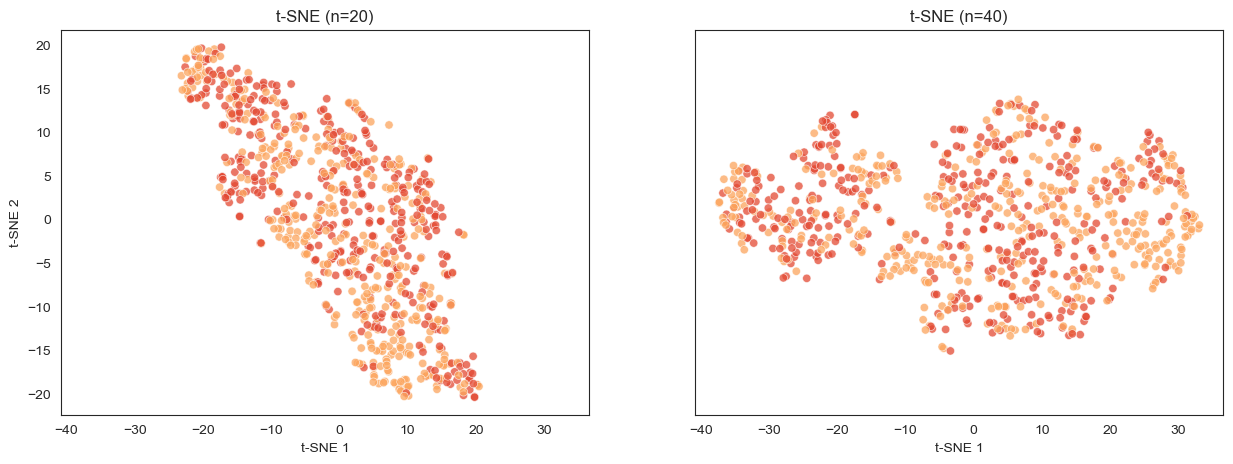

In [21]:
# Load the embeddings
train_embeddings, train_labels = load_embeddings(train_path)
test_embeddings, test_labels = load_embeddings(test_path)

# Split the train into train and validation
train_embeddings, val_embeddings, train_labels, val_labels = train_test_split(train_embeddings, train_labels, test_size=0.2, random_state=seed)

# Define the datasets
train_dataset = EmbeddingDataset(train_embeddings, train_labels)
val_dataset = EmbeddingDataset(val_embeddings, val_labels)
test_dataset = EmbeddingDataset(test_embeddings, test_labels)

# Define the dataloaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Visualize the embeddings using increasing number of principal components that go into t-sne
n = min(len(train_embeddings), 1000)
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True, sharex=True)
visualize_embeddings(train_embeddings[:n], train_labels[:n], n_components=20, ax=axs[0])
visualize_embeddings(train_embeddings[:n], train_labels[:n], n_components=40, ax=axs[1])

Clearly, we can see that the quality of the embeddings is not so good as there is a lot of overlap. Therefore, we can expect the classifier to perform relatively poorly.

c. Build a classifier based on the DNA embeddings

In [22]:
# Train the model first
model_path = f"models/customemb_promclf.pth"
if not os.path.exists(model_path):

  # Define the classifier
  print("Training the classifier...")
  clf = DnaBertHead(input_size=dna_config.hidden_size, output_size=1, hidden_dimensions=[30], dropout_rate=0.0, activation=nn.ReLU()).to(device)
  clf_optimizer = optim.AdamW(clf.parameters(), lr=1e-2, weight_decay=0.0)
  criterion = nn.BCEWithLogitsLoss()

  # Train the classifier
  best_val_loss, best_val_acc = train_loop(clf, train_loader, val_loader, criterion, clf_optimizer, device, epochs=100, patience=5)

  # Save the trained model
  os.makedirs("models", exist_ok=True)
  torch.save(clf, model_path)

# Load the trained model
else:
  print("Loading the trained classifer...")
  clf = torch.load(model_path)

# Evaluation
print("-"*50)
criterion = nn.BCEWithLogitsLoss()
avg_test_loss, test_acc = eval_loop(clf, test_loader, criterion, device)

Loading the trained classifer...
--------------------------------------------------
Test cost = 0.613097 test acc = 0.656000


### 2.5. Additional question (1 pt)

Now we change mask_length = 1 (already changed, you do not need to implement anything).
Let's run the code below and check the accuracy.

Question: What is the final masked token prediction accuracy? How do you explain this?

**Answer**: The final prediction accuracy is high, reaching 92%. This robust performance is attributed to the simplicity of the prediction task when masking only one k-mer. To illustrate, consider the sequence ABCDEF, tokenized into 3-mers as [ABC, BCD, CDE, DEF]. If we mask a single k-mer, let's say BCD, we retain access to the surrounding k-mers, simplifying the prediction task. On the other hand, masking multiple k-mers, such as BCD and CDE, introduces additional complexity. In this scenario, each masked k-mer has access to only one direct neighbor, making the prediction task inherently more challenging.

In [23]:
# Set the mask length to 1, the rest of parameters are the same as in 2.3
mask_length = 1

# Load the data
input_ids, segment_ids, masked_lm_labels, labels_idx, labels, attention_masks = data.generate_masked_data(raw_training_data, tokenizer, max_len=dna_max_len, max_mask=max_dna_mask, k=mask_length, mask_rate=0.05, max_size=dataset_size)
test_input_ids, test_segment_ids, test_masked_lm_labels, test_labels_idx, test_labels, test_attention_masks = data.generate_masked_data(raw_test_data, tokenizer, max_len=dna_max_len, max_mask=max_dna_mask, k=mask_length, mask_rate=0.05, max_size=dataset_size)

train_dataset = TensorDataset(input_ids, segment_ids, masked_lm_labels, labels_idx, labels, attention_masks)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_input_ids, test_segment_ids, test_masked_lm_labels, test_labels_idx, test_labels, test_attention_masks)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the model path
model_path = f"models/dna_embedder_masklen-{mask_length}.pth"

# Get the embedder model
dummy_embedder = get_custom_embedding_model(model_path, dna_config, train_loader, test_loader, device, epochs=50, verbose=True)

# Get the trained embeddings model accuracy, also get the last attention layer
average_train_acc, _ = evaluation.model_masked_label_accuracy(dummy_embedder, train_loader, device)
average_test_acc, last_test_attention = evaluation.model_masked_label_accuracy(dummy_embedder, test_loader, device)
print('Train Acc =', '{:.6f}'.format(average_train_acc), 'Eval Acc =', '{:.6f}'.format(average_test_acc))

Loading the trained model...
Number of trainable model parameters: 118869
Train Acc = 0.922506 Eval Acc = 0.924429


## 3. Using foundation model (5 pts)

---

### 3.1. Introduction

In this section, we aim to use a foundation model, DNABERT, to perform promoter detection.
A foundation model is a model pretrained on large datasets. Foundation models serve as the foundational building blocks upon which various applications can be constructed.

Here, we use DNABERT as the foundation model. We first apply it on DNA sequence to get the embedding. Then, we train a classifier on the embedding as in Section 2. Please follow this [link](https://github.com/Zhihan1996/DNABERT_2) to load the foundation model.

### 3.2. Implementation

**Consider this situation:** You get a dataset about promoter detection, and you build your model to perform the task as in Section 2. However, the performance is not good since the model is not strong enough. Suddenly, you think we can use a large pre-trained model to embed DNA sequences. Then, you search online and find the pre-trained model [DNABERT](https://github.com/Zhihan1996/DNABERT_2). Now, you want to perform promoter detection using the pre-trained DNABERT.

There is no coding framework in this section. Just make things work (get good test accuracy) using the pre-trained model!

Hint: 
- We encourage you to create a **new environment** following the instructions of Section 3 in this [link](https://github.com/Zhihan1996/DNABERT_2). (When you face the error "The model class you are passing has a config_class attribute that is not consistent with the config class you passed ...", creating a new environment can save you.)
- Section 4 in this [link](https://github.com/Zhihan1996/DNABERT_2) shows you how to load and use the pre-trained foundation model.

a. Load the dataset.

In [24]:
# Load raw data, shuffle first so we get a random sample
raw_training_data = data.load_csv("./data/train.csv").sample(frac=1).reset_index(drop=True)
raw_test_data = data.load_csv("./data/test.csv").sample(frac=1).reset_index(drop=True)

# Define the tokenizer
os.environ["TOKENIZERS_PARALLELISM"] = "false"
tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True) 

# Define training hyperparameters
dna_max_len = 298
dataset_size = 1000

# Load the data
input_ids, labels = data.generate_labeled_data(raw_training_data, tokenizer, max_len=dna_max_len, max_size=dataset_size)
test_input_ids, test_labels = data.generate_labeled_data(raw_test_data, tokenizer, max_len=dna_max_len, max_size=dataset_size)

# Define data loaders
train_dataset = TensorDataset(input_ids, labels)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

test_dataset = TensorDataset(test_input_ids, test_labels)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

b. Get the embeddings of the DNA sequences using pretrained model.

Hint: 
- This step can take some time. Thus, you can start with a small sample size, and then increase it when you have made sure that everything works correctly.
- After getting the embeddings, you can save them so that you can directly load them next time without running the foundation model.

In [25]:
# Load the pretrained model
model = AutoModel.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True).to(device)

# Turn off the gradients
for param in model.parameters():
    param.requires_grad = False

# Save the training embeddings
train_path = os.path.join("embeddings", "dnabert", "train")
if not os.path.exists(train_path):
    # First create the path
    os.makedirs(train_path, exist_ok=True)

    # Save the embeddings 
    print("Saving dnabert train embeddings")
    save_embeddings(train_loader, model, train_path, kind="dnabert")

# Save the test embeddings
test_path = os.path.join("embeddings", "dnabert", "test")
if not os.path.exists(test_path):
    # First create the path
    os.makedirs(test_path, exist_ok=True)

    # Save the embeddings
    print("Saving dnabert test embeddings")
    save_embeddings(test_loader, model, test_path, kind="dnabert")

/Users/ludekcizinsky/.cache/huggingface/modules/transformers_modules/zhihan1996/DNABERT-2-117M/1d020b803b871a976f5f3d5565f0eac8f2c7bb81/bert_layers.py:125: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of the model checkpoint at zhihan1996/DNABERT-2-117M were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expec

c. (Load) And visualize the embeddings

Using random seed: 128
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
 - point 0 of 800
Input similarities computed in 0.36 seconds (sparsity = 0.147384)!
Learning embedding...
Iteration 50: error is 64.058565 (50 iterations in 0.48 seconds)
Iteration 100: error is 59.417625 (50 iterations in 0.25 seconds)
Iteration 150: error is 59.126716 (50 iterations in 0.26 seconds)
Iteration 200: error is 59.090729 (50 iterations in 0.26 seconds)
Iteration 250: error is 2.439225 (50 iterations in 0.25 seconds)
Iteration 300: error is 0.847263 (50 iterations in 0.21 seconds)
Iteration 350: error is 0.733879 (50 iterations in 0.24 seconds)
Iteration 400: error is 0.707565 (50 iterations in 0.23 seconds)
Iteration 450: error is 0.691317 (50 iterations in 0.23 seconds)
Iteration 500: error is 0.683484 (50 iterations in 0.22 seconds)
Iteration 550: error is 0.677107 (50 iterations in 0.21 seconds)
Iteration 600: error is 0.671298 (50 it

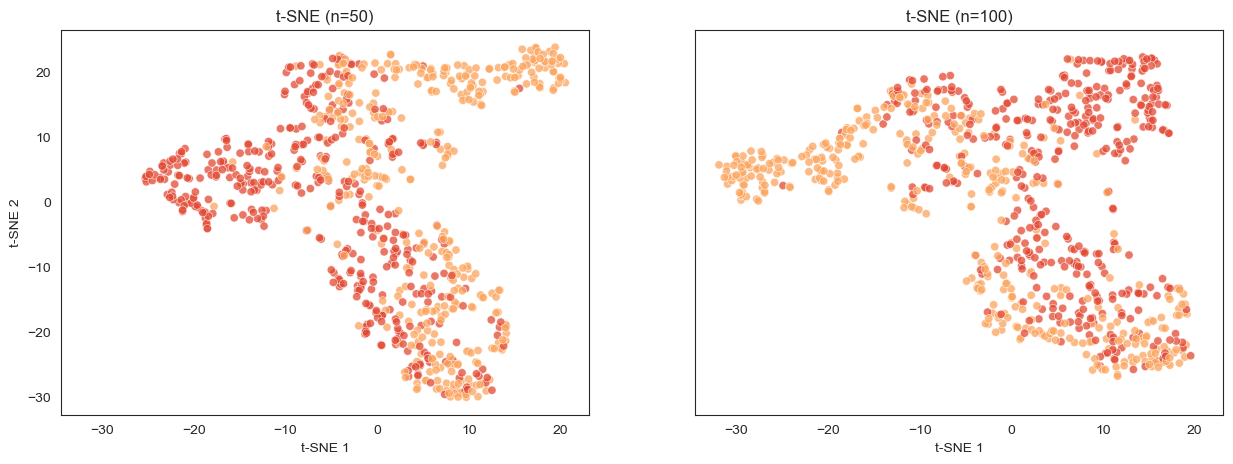

In [26]:
# Load the embeddings with labels
train_embeddings, train_labels = load_embeddings(train_path)
test_embeddings, test_labels = load_embeddings(test_path)

# Split the train into train and validation
train_embeddings, val_embeddings, train_labels, val_labels = train_test_split(train_embeddings, train_labels, test_size=0.2, random_state=seed)

# Define the datasets
train_dataset = EmbeddingDataset(train_embeddings, train_labels)
val_dataset = EmbeddingDataset(val_embeddings, val_labels)
test_dataset = EmbeddingDataset(test_embeddings, test_labels)

# Define the dataloaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Visualize the embeddings using increasing number of principal components that go into t-sne
n = min(len(train_embeddings), 1000)
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True, sharex=True)
visualize_embeddings(train_embeddings[:n], train_labels[:n], n_components=50, ax=axs[0])
visualize_embeddings(train_embeddings[:n], train_labels[:n], n_components=100, ax=axs[1])

This looks way more promising than the embeddings we obtained in Section 2.4.5. We can see that the embeddings are well separated, which should allow the classifier to perform well.

d. Train a classifier.

Hint: It is easy to overfit on the training set. Try to avoid overfitting.

In [27]:
# Train the model first
model_path = f"models/dnabert_promclf.pth"
if not os.path.exists(model_path):

  # Define the classifier
  print("Training the model...")
  clf = DnaBertHead(input_size=768, output_size=1, hidden_dimensions=[384, 192, 96], dropout_rate=0.05, activation=nn.ReLU()).to(device)
  clf_optimizer = optim.AdamW(clf.parameters(), lr=1e-1, weight_decay=0.05)
  criterion = nn.BCEWithLogitsLoss()

  # Train the classifier
  best_val_loss, best_val_acc = train_loop(clf, train_loader, val_loader, criterion, clf_optimizer, device, epochs=100, patience=15)

  # Save the trained model
  os.makedirs("models", exist_ok=True)
  torch.save(clf, model_path)

# Load the trained model
else:
  print("Loading the trained model...")
  clf = torch.load(model_path)

# Evaluation
print("-"*50)
criterion = nn.BCEWithLogitsLoss()
avg_test_loss, test_acc = eval_loop(clf, test_loader, criterion, device)

Loading the trained model...
--------------------------------------------------
Test cost = 0.414999 test acc = 0.836000


We indeed obtain better performance using the DNABERT embeddings. This is likely due to the fact that DNABERT was trained on a much larger dataset, allowing it to learn more general features. In addition, it is important to note that given we have a balanced distribution of positive and negative labels, it is possible to use `accuracy` to evaluate the model.

---